# Baby Cry Classification using Machine Learning Algorithms Phase 2

## Overview

**Project Goal**: The entire project (1st & 2nd phases) aims to classify baby cry reason based on the acoustic cry signals and babies' demographic features using machine learning techniques. The 2nd phase of our research will focus on building a new classifier based on  the insight from the first phase to achieve better F1 score and classification accuracy.

**Summary of Codebook**: In this codebook, we design a process to extract the Local Binary Pattern (LBP) features and Histogram of Oriented Gradient features from spectrogram images, and extract acoustic features MFCC, LPCC, F1, F2, and F3 from audio files. The classification algorithms include KNN, Random Forest, SVM, XGBoost, and Fuzzy SVM for Class Imbalanced Learning.

**Inputs**:
*   Visual Features: LBP and HOG features extracted from Spectrogram images.
*   Acoustic Features: MFCC, LPCC, F1,F2,F3 features extracted from audios.
*   Combined feature set that includes both visual features and acoustic features.









**Binary Classification Outputs**: Labels of cry reasons:
*   Hungry vs. Not Hungry











### Structure of Code

        I. Install and Import Packages

        II. Load Dataset- audio files

        III. Exploratory Data Analysis

        IV. Pre-processing and Feature Extraction

        V. PCA/Feature Selection

        VI. Build Classifier

        VII. Run all models and Report Performance

In [ ]:
# Please change the file path to where you have the input data saved.
project_path = "/content/gdrive/MyDrive/DS5500_Data/"

## I. Install and Import packages

In [ ]:
!pip install pydub praat-parselmouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 22.3 MB/s eta 0:00:00


In [ ]:
!pip install pydub

In [ ]:
! pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
# load required packages
import math
import os
import os
import cv2
from skimage.feature import local_binary_pattern
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
import pandas as pd
import numpy as np
import pydub
import parselmouth
from parselmouth import praat
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.utils import make_chunks
from os import walk
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns
%matplotlib inline
from statistics import mean
from matplotlib import pyplot, cm
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler,BorderlineSMOTE
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import sklearn
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
from numpy.linalg import eigh
from sklearn.svm import SVC
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Layer, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Embedding, Input, LayerNormalization, MultiHeadAttention
from keras.layers import MultiHeadAttention as MHA
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from PIL import Image
from IPython.display import display
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
from tqdm.auto import tqdm
import soundfile as sf
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import RFECV

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## II. Load Dataset- audio files

In this phase, we plan to record babies’ cries associated with belly pain, burping, discomfort, and tiredness and combine these new recordings with the Donate-A-Cry Dataset to build a new dataset for research use. The Donate-A-Cry corpus dataset consists of 457 children's cry audio files along with metadata for babies’ demographic information and cry reasons.

In [ ]:
# mount google drive to access files and folders
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Convert new iphone recorded file to wave form and save them into the input data folder
file_path_df = pd.DataFrame(columns=['file_name','audio_type'])
sub_folder_name = ["belly_pain","burping","discomfort","tired","hungry"]

# Generate a datafram that contains the filename and locations for all the new recordings in the new_recordings folder.
for t in sub_folder_name:
    wav_files = [project_path + "new_recordings/" +t+"/"+ f for f in os.listdir(project_path +"/new_recordings/"+t) if f.endswith(".m4a")]
    short_file_names = [f.split(".")[0] for f in os.listdir(project_path +"/new_recordings/"+t) if f.endswith(".m4a")]
    temp_df = pd.DataFrame({ "file_name" : wav_files,
                            "short_file_name" : short_file_names,
                            "audio_type" : t})
    file_path_df = pd.concat([file_path_df, temp_df], ignore_index=True)

label_dict = {
    "belly_pain": "bp",
    "burping": "bu",
    "discomfort": "dc",
    "hungry": "hu",
    "tired": "ti"
}

# Go through all the files in the new_recordings folder.
# If there is new file that doesn't exist in the audio folder as a wav file, we convert it to a wav file and then save it to the audio folder.
for i in range(len(file_path_df)):
  m4a_file = file_path_df['file_name'][i]
  audio_path = project_path+f"/audio/{file_path_df['audio_type'][i]}/"+file_path_df['short_file_name'][i] + ".wav"
  if not os.path.isfile(audio_path):
    track = AudioSegment.from_file(m4a_file,  format= 'm4a')
    print(m4a_file)
    #track.export(project_path+f"/new_recordings_wav/{file_path_df['audio_type'][i]}/"+file_path_df['short_file_name'][i] + ".wav", format='wav')
    #track.export(project_path+f"/audio/{file_path_df['audio_type'][i]}/"+file_path_df['short_file_name'][i] + ".wav", format='wav')

In [ ]:
# create a data frame that contains all file path of audio files in the audio folder and associated label for cry reason
dic_path = os.getcwd()
sub_folder_name = ["belly_pain","burping","discomfort","hungry","tired"]
file_path_df = pd.DataFrame(columns=['file_name','audio_type'])
for t in sub_folder_name:
    wav_files = [project_path+"audio/"+t+"/"+ f for f in os.listdir(project_path+"audio/"+t) if f.endswith(".wav")]
    temp_df = pd.DataFrame({ "file_name" : wav_files, "audio_type" : t})
    file_path_df = pd.concat([file_path_df, temp_df], ignore_index=True)

## III. Exploratory Data Analysis

In [ ]:
# extract length of file, age and gender of babies from the files and append to the dataframe

def calculate_audio_length(file_path):
    # load audio file using file path and calculate the length of audio in minutes
    y,sr = librosa.load(file_path)
    length = len(y)/sr
    return length

def extract_gender(file_path):
    # extract information on gender from file name
    g = file_path.split("-")[-3]
    if g == "m":
        return "Male"
    else: return "Female"

def extract_age(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("-")[-2])
    return a

def extract_audio_index(file_path):
  # extract audio index from file name
    audio_index = int(file_path.split("/")[-1].split("-")[0])
    return audio_index

def identify_source(audio_index):
  # extract information on age in month from file name
  if audio_index <=456:
    return "Donate-A-Cry Dataset"
  else:
    return "New Recordings"

def identify_binary_cry_type(cry_reason):
  if cry_reason == "hungry":
    return "hungry"
  else:
    return "not hungry"

In [ ]:
# Extract the demographic information from the audio file names
#file_path_df["length"] = file_path_df["file_name"].map(lambda x:calculate_audio_length(x))
file_path_df["gender"] = file_path_df["file_name"].map(lambda x:extract_gender(x))
file_path_df["age_in_months"] = file_path_df["file_name"].map(lambda x:extract_age(x))
file_path_df["audio_index"] = file_path_df["file_name"].map(lambda x:extract_audio_index(x))
file_path_df["source"] = file_path_df["audio_index"].map(lambda x:identify_source(x))
file_path_df["audio_type"] = file_path_df["audio_type"].map(lambda x:identify_binary_cry_type(x))

### Age

In [ ]:
# Get the statistics on age of babies
file_path_df['age_in_months'].apply(["max","median","min"])

max       72.0
median    26.0
min        4.0
Name: age_in_months, dtype: float64

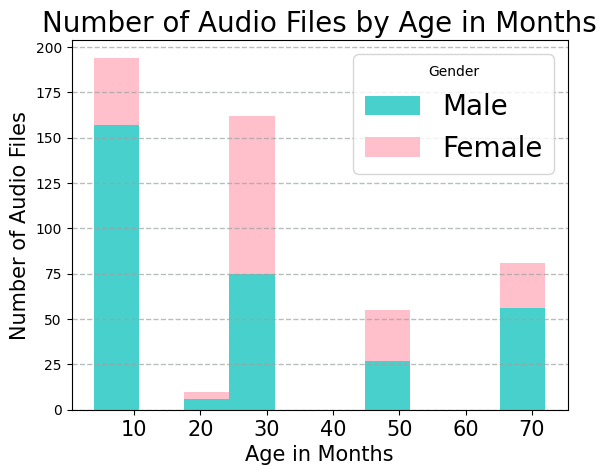

In [ ]:
# Create list of data according to different gender
x1 = list(file_path_df[file_path_df['gender'] == "Male"]['age_in_months'])
x2 = list(file_path_df[file_path_df['gender'] == "Female"]['age_in_months'])

colors=['mediumturquoise', 'pink']
names=['Male', 'Female']

plt.hist([x1, x2], color=colors, label=names, stacked = True)
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Age in Months', fontsize = 15)
plt.ylabel('Number of Audio Files', fontsize = 15)
plt.title('Number of Audio Files by Age in Months',fontsize = 20)
plt.legend(title='Gender', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

### Cry Reason

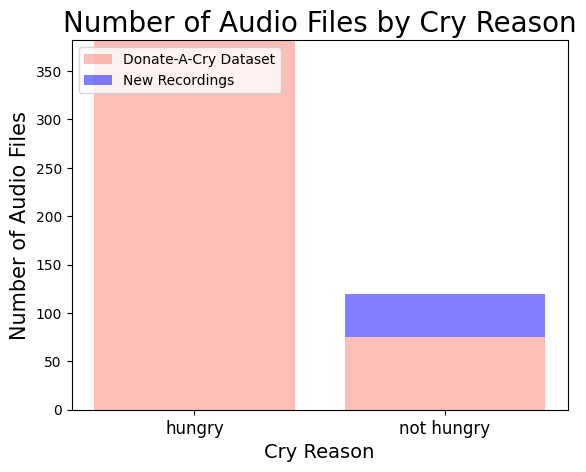

In [ ]:
# Plot number of file audios by cry reason and souce
count_by_type = pd.DataFrame(file_path_df.groupby(['audio_type','source']).size()).rename(columns={0: "count"})
count_by_type.reset_index(inplace=True)
statistics = pd.pivot_table(count_by_type, values='count', index='audio_type', columns='source',fill_value=0)
groups = statistics.index.tolist()
values1 = statistics['Donate-A-Cry Dataset']
values2 = statistics['New Recordings']
fig, ax = plt.subplots()
ax.bar(groups, values1, color = "salmon", alpha = 0.5, label = "Donate-A-Cry Dataset")
ax.bar(groups, values2, bottom = values1, color = "blue", alpha = 0.5, label = "New Recordings")
plt.xlabel('Cry Reason', fontsize = 14)
plt.ylabel('Number of Audio Files', fontsize = 15)
plt.title('Number of Audio Files by Cry Reason', fontsize = 20)
ax.legend(loc=2)
plt.xticks(fontsize = 12)
plt.show()


## IV. Pre-processing and Feature Extraction

### A. Extract Visual Features from Spectrogram Images

**Local Binary Pattern (LBP)** was introduced by Ojala et al. in 1994, which characterizes an image with local spatial patterns and grayscale contrast in the image with three main steps.


**(1)** Convert audio files into spectrogram images

**(2)** Convert the RGB image to grayscale.

**(3)** Extract LBP-based features: Consider the spectrogram as a texture and use the Local Binary Pattern (LBP) operator to get features


In [ ]:
# convert audio files into spectrogram images if spectrogram image doesn't exist
# second_num = 6
# # this is the number of samples in a window per fft
# n_fft = 2048
# # The amount of samples we are shifting after each fft
# hop_length = 512

# for i in tqdm(range(file_path_df.shape[0])):
#   # check if spectrogram exists in the image folder
#   plt_image_path = project_path + f"image/{str(file_path_df['audio_type'][i])},audio_{str(file_path_df['audio_index'][i])}_1.jpg"
#   if not os.path.isfile(plt_image_path):  # if it doesn't exists in the image folder
#     signal, sr = librosa.load(file_path_df['file_name'][i])
#     signal, _ = librosa.effects.trim(signal)
#     j = 0
#     # cut the wav file into segment of 6 seconds and then convert it to spectrograms
#     while len(signal)>= second_num*sr:
#         signal_seg = signal[:second_num*sr]
#         signal = signal[second_num*sr:]
#         j += 1
#         # Generate Mel-spectrogram
#         mel_signal = librosa.feature.melspectrogram(y=signal_seg, sr=sr, hop_length=hop_length, n_fft=n_fft)
#         spectrogram = np.abs(mel_signal)
#         power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
#         plt.figure(figsize=(3, 1))
#         librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma',hop_length=hop_length)
#         plt.axis('off')
        #plt.savefig(project_path + f"image/{str(file_path_df['audio_type'][i])},audio_{str(file_path_df['audio_index'][i])}_{j}.jpg", bbox_inches='tight', dpi=300)

In [ ]:
# Load spectrogram images
option  = "image"
images_paths = os.listdir(project_path + option)
images = []
y = []
image_size = 200
class_name_dic = {
    "discomfort": 0,
    "burping":0,
    "hungry":1,
    "tired":0,
    "belly_pain":0
}
for path in tqdm(images_paths):
  img = cv2.imread(project_path + f"{option}/" + path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, dsize=(image_size,image_size))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  class_name = path.split(",")[0]
  images.append(img)
  y.append(class_name_dic[class_name])
images_array = np.array(images)
y = np.array(y)

  0%|          | 0/509 [00:00<?, ?it/s]

In [ ]:
classnames = ['not hungry','hungry']

In [ ]:
# generate histogram based on LBP 2D array
lbps = []
for image in tqdm(images_array):
  lbp = local_binary_pattern(image, P=8, R=1)
  lbps.append(lbp)
X_lbps = np.array(lbps)

  0%|          | 0/509 [00:00<?, ?it/s]

In [ ]:
# generate histogram based on the LBP 2D array
cell_width = 4
bins_num = 64
X_list = []
for x in tqdm(X_lbps):
  grid = np.arange(0, image_size +1, image_size//cell_width)
  cell_histograms = []
  cell_num = len(grid)
  for i in range(cell_num - 1):
      for j in range(cell_num - 1):
          cell = x[grid[i]:grid[i+1], grid[j]:grid[j+1]]
          cell_hist = np.histogram(cell, bins=bins_num)[0]
          cell_histograms.append(cell_hist)
  image_histogram = np.array(cell_histograms).flatten()
  X_list.append(image_histogram)
X_lbp_features  = np.array(X_list)

  0%|          | 0/509 [00:00<?, ?it/s]

**Histogram of Oriented Gradients (HOG)** describes the local object appearance and shape within an image by the distribution of intensity gradients or edge directions with 3 main steps: (1) Divide the image  into small connected cells; (2) Calculate the magnitude of horizontal and vertical gradients at every pixel; and (3) Generate and compile histograms of gradients.

  0%|          | 0/509 [00:00<?, ?it/s]

<ipython-input-20-07579f4e9e01>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_histogram, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)


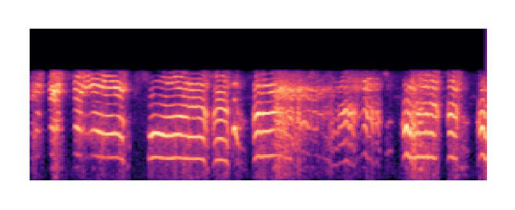

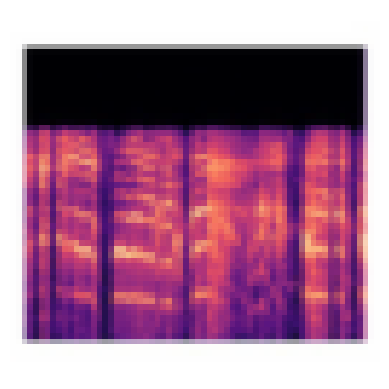

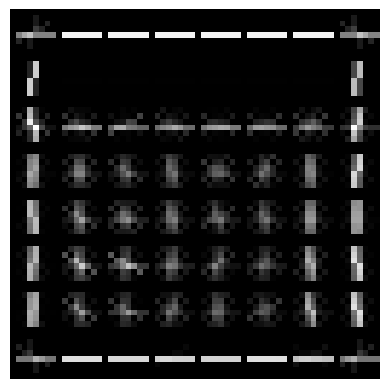

In [ ]:
# Generate HOG based features
hog_images = []
hog_histograms = []
# reading the image
for i in tqdm(range(len(images_paths))):
  img = imread(project_path + "image/" + images_paths[i])
  # resizing image
  resized_img = resize(img, (64, 64))
  # creating hog features
  hog_histogram, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
  hog_images.append(hog_image)
  hog_histograms.append(hog_histogram)
  if i==0:
    plt.axis("off")
    plt.imshow(img)
    plt.show()
    plt.axis("off")
    plt.imshow(resized_img)
    plt.show()
    plt.axis("off")
    plt.imshow(hog_image, cmap="gray")
    plt.show()
hog_images = np.array(hog_images)
X_hog_features = np.array(hog_histograms)

Combine LBP features with HOG features

In [ ]:
X_lbp_features.shape

(509, 1024)

In [ ]:
X_hog_features.shape

(509, 1764)

In [ ]:
X = np.hstack((X_lbp_features,X_hog_features))
X.shape

(509, 2788)

In [ ]:
# Train test split
X_index_list = list(file_path_df["audio_index"])
y_cry_reason = file_path_df['audio_type']
# X_train_index,X_test_index,_,_ = train_test_split(X_index_list,
#                                                   y_cry_reason,
#                                                   test_size=0.25,
#                                                   stratify=y_cry_reason,
#                                                   shuffle=True,
#                                                   random_state=100)

In [ ]:
# In order to ensure the multiclass and binary classification use the same test sets. We manually assign the indexes for train and test set.
# these are the random train index generated from multiclass classification notebook
X_train_index = [457, 7, 459, 4, 338, 292, 34, 287, 200, 494, 9, 94, 155, 220, 164, 445, 490, 311, 75, 179, 372, 148, 397, 82, 136, 496, 422, 131, 196, 425, 201, 206, 491, 380, 79, 50, 334, 147, 229, 166, 406, 98, 474, 395, 105, 354, 499, 353, 231, 95, 377, 341, 362, 15, 116, 203, 217, 170, 145, 156, 160, 92, 245, 66, 244, 364, 132, 251, 412, 376, 109, 378, 471, 473, 317, 61, 227, 324, 81, 432, 436, 22, 460, 11, 415, 262, 199, 385, 278, 356, 329, 112, 492, 175, 243, 151, 482, 204, 194, 70, 464, 241, 100, 408, 417, 134, 325, 430, 205, 409, 165, 288, 123, 294, 270, 159, 345, 405, 479, 465, 101, 448, 71, 128, 274, 273, 261, 144, 177, 493, 393, 104, 277, 221, 333, 265, 124, 361, 257, 118, 39, 21, 102, 83, 283, 119, 351, 122, 69, 304, 173, 181, 475, 8, 62, 234, 162, 306, 370, 248, 198, 305, 114, 315, 215, 347, 90, 339, 303, 13, 429, 483, 302, 352, 35, 169, 290, 489, 275, 433, 289, 360, 135, 480, 394, 296, 279, 469, 59, 458, 91, 348, 250, 213, 373, 346, 40, 363, 23, 157, 435, 86, 197, 463, 440, 96, 486, 254, 207, 172, 400, 120, 410, 190, 388, 242, 187, 344, 149, 219, 340, 89, 256, 97, 36, 212, 32, 301, 153, 454, 237, 99, 298, 368, 230, 158, 161, 12, 226, 51, 240, 107, 167, 439, 472, 495, 31, 493, 246, 27, 336, 18, 450, 214, 60, 297, 184, 209, 322, 113, 33, 193, 48, 328, 310, 434, 386, 446, 316, 260, 259, 497, 252, 117, 437, 441, 481, 314, 41, 239, 125, 0, 152, 374, 53, 466, 255, 461, 264, 73, 186, 424, 414, 37, 121, 426, 127, 76, 467, 282, 456, 141, 202, 64, 224, 236, 276, 312, 235, 271, 411, 57, 431, 133, 24, 300, 280, 238, 195, 30, 452, 331, 210, 140, 399, 468, 29, 42, 126, 74, 150, 478, 407, 343, 293, 14, 85, 487, 26, 267, 470, 178, 208, 358, 319, 453, 44, 423, 225, 52, 188, 391, 5, 154, 272, 396, 350, 383, 389, 77, 443, 263, 335, 163, 387, 10, 488, 247, 253, 176, 313, 192, 55, 191, 111, 211]

In [ ]:
# these are the random test index generated from multiclass classification notebook
X_test_index = [369, 418, 281, 49, 168, 143, 218, 447, 174, 146, 137, 268, 93, 6, 232, 139, 103, 390, 476, 498, 285, 80, 404, 327, 442, 110, 68, 307, 451, 72, 444, 485, 286, 171, 46, 17, 349, 359, 16, 355, 455, 291, 129, 38, 449, 258, 484, 321, 56, 2, 58, 222, 84, 330, 308, 342, 295, 228, 366, 309, 323, 438, 392, 477, 3, 1, 500, 381, 419, 87, 43, 420, 365, 130, 54, 189, 183, 421, 63, 138, 320, 28, 45, 216, 371, 142, 223, 67, 379, 398, 266, 403, 357, 318, 185, 401, 88, 249, 233, 299, 65, 19, 428, 384, 337, 284, 413, 427, 78, 106, 332, 108, 180, 402, 326, 375, 47, 416, 115, 382, 25, 367, 269, 462, 20, 182]

In [ ]:
audio_type_dict = pd.Series(file_path_df['audio_type'].values,file_path_df['audio_index']).to_dict()

In [ ]:
def find_cry_reason(audio_index):
  type = audio_type_dict[audio_index]
  return type

In [ ]:
image_segment_audio_index = pd.DataFrame(images_paths)[0].apply(lambda x: x.split(',')[1])
image_segment_audio_index = image_segment_audio_index.apply(lambda x: x.split('_')[1]).astype(int)
vf_df= pd.DataFrame(X)
vf_df['audio_index'] = image_segment_audio_index
vf_df['cry_reason'] = y
vf_df.columns = [f"vf_{i}" for i in range(X.shape[1])] + ['audio_index','cry_reason']

In [ ]:
### Split data into train and test sets
train_df_vf = vf_df[vf_df['audio_index'].isin(X_train_index).tolist()]
test_df_vf = vf_df[vf_df['audio_index'].isin(X_test_index)]
col = ['audio_index','cry_reason']
X_train_vf = train_df_vf[[x for x in train_df_vf.columns if x not in col]]
y_train_vf = train_df_vf['cry_reason']
X_test_vf = test_df_vf[[x for x in test_df_vf.columns if x not in col]]
y_test_vf = test_df_vf['cry_reason']

### B. Extract Acoustic Features from Audio Files

| Acoustic Feature | Definition | Number of Features Extracted per Frame |
| :-: |:-- | :-: |
| Mel-frequency cepstral coefficients (MFCC)| A set of features derived from log short-term power spectrum of a sound signal  on a nonlinear mel scale of frequency| 39 |
| Linear predictive cepstrum coefficient (LPCC)|It is the spectral feature derived from the linear predictive analysis to represent the emotion-specific phonetic representation of the speech signal.| 39 |
| Formant F1| Lowest resonant frequency of the vocal tract influenced by vertical position of tongue within the mouth and provides spectral information about the quantitative properties of the vocal tract. | 7 |
| Formant F2| Second resonant frequency of the vocal tract  influenced by the horizontal position of the tongue within the mouth provides spectral information about the quantitative properties.| 7  |
| Formant F3| Third resonant frequency of the vocal tract influenced by both vertical and horizontal position of the tongue within the mouth and provides spectral information of the vocal tract.| 7  |

In [ ]:
def acoustic_feature_extraction(audio_df = file_path_df, seg_dur = 6):
  gender = []
  age = []
  cry_reason = []
  audio_index = []
  mfccs = []
  mfccs_mean = []
  mfccs_med = []
  mfccs_sd = []
  lpccs_coeff = []
  lpccs_mean = []
  lpccs_med = []
  lpccs_sd = []
  f1_mean = []
  f2_mean = []
  f3_mean = []
  f1_med = []
  f2_med = []
  f3_med = []
  f1_min = []
  f2_min = []
  f3_min = []
  f1_max = []
  f2_max = []
  f3_max = []
  f1_r = []
  f2_r = []
  f3_r = []
  f1_bwd = []
  f2_bwd = []
  f3_bwd = []
  f1_sd = []
  f2_sd = []
  f3_sd = []
  for i in tqdm(range(audio_df.shape[0])):
    #read the audio file;returns the audio time series and sample rate
    f = audio_df['file_name'][i]
    audio, sr = librosa.load(f)
    seg_len = sr * seg_dur
    seg = 0
    while len(audio)>= seg_len:
      #get gender of the baby from the df
      gender.append(audio_df['gender'][i])
      #get age of the baby from the df
      age.append(audio_df['age_in_months'][i])
      #get the cry reason label of the audio from the df
      cry_reason.append(audio_df['audio_type'][i])
      # Start from dividing the sound signal into the form of frames with a duration of 1-seconds
      audio_seg = audio[:seg_len]
      audio = audio[seg_len:]

      # Extract Mel-frequency cepstral coefficients (MFCCs) to represent the short-term power spectrum of sound.
      mfcc = librosa.feature.mfcc(y=audio_seg, sr=sr, n_mfcc=13)
      mfccs.append(mfcc)
      # calculate mean, median and std deviation of each MFCC coeff
      mfccs_mean.append(np.mean(mfcc.T,axis = 0))
      mfccs_med.append(np.median(mfcc.T,axis = 0))
      mfccs_sd.append(np.std(mfcc.T,axis = 0))

      # Extract formants F1, F2 and F3 at each glottal pulse
      out_filename = f"segment{str(1)}.wav"
      sf.write(project_path+ "/export_audio/"+ out_filename, audio_seg, sr)
      sound = parselmouth.Sound(project_path+ "/export_audio/"+ out_filename)
      f0min=75
      f0max=300
      pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
      formants = praat.call(sound, "To Formant (burg)", 0.0025, 3, 5500, 0.025, 50)
      numPoints = praat.call(pointProcess, "Get number of points")
      time_f1 = []
      time_f2 = []
      time_f3 = []
      # extract formants only at glottal pulses
      for j in range(0, numPoints):
        j += 1
        time = praat.call(pointProcess, "Get time from index", j)
        f1 = praat.call(formants, "Get value at time", 1, time, 'Hertz', 'Linear')
        f2 = praat.call(formants, "Get value at time", 2, time, 'Hertz', 'Linear')
        f3 = praat.call(formants, "Get value at time", 3, time, 'Hertz', 'Linear')
        time_f1.append(f1)
        time_f2.append(f2)
        time_f3.append(f3)
      time_f1 = [f1 for f1 in time_f1 if str(f1) != 'nan']
      time_f2 = [f2 for f2 in time_f2 if str(f2) != 'nan']
      time_f3 = [f3 for f3 in time_f3 if str(f3) != 'nan']
      #calculate mean, median, min, max, range and bandwidth of formants across pulses
      if len(time_f1)== 0:
        f1_mean.append(0)
        f1_min.append(0)
        f1_max.append(0)
        f1_r.append(0)
        f1_med.append(0)
        f1_bwd.append(0)
        f1_sd.append(0)
      else:
        f1_mean.append(np.mean(time_f1))
        f1_min.append(min(time_f1))
        f1_max.append(max(time_f1))
        f1_r.append(max(time_f1)-min(time_f1))
        f1_med.append(np.median(time_f1))
        f1_bwd.append(np.mean(time_f1)-min(time_f1))
        f1_sd.append(np.std(time_f1))
      if len(time_f2)== 0:
        f2_mean.append(0)
        f2_min.append(0)
        f2_max.append(0)
        f2_r.append(0)
        f2_med.append(0)
        f2_bwd.append(0)
        f2_sd.append(0)
      else:
        f2_mean.append(np.mean(time_f2))
        f2_min.append(min(time_f2))
        f2_max.append(max(time_f2))
        f2_r.append(max(time_f2)-min(time_f1))
        f2_med.append(np.median(time_f2))
        f2_bwd.append(np.mean(time_f2)-min(time_f1))
        f2_sd.append(np.std(time_f2))
      if len(time_f3)== 0:
        f3_mean.append(0)
        f3_min.append(0)
        f3_max.append(0)
        f3_r.append(0)
        f3_med.append(0)
        f3_bwd.append(0)
        f3_sd.append(0)
      else:
        f3_mean.append(np.mean(time_f3))
        f3_min.append(min(time_f3))
        f3_max.append(max(time_f3))
        f3_r.append(max(time_f3)-min(time_f1))
        f3_med.append(np.median(time_f3))
        f3_bwd.append(np.mean(time_f3)-min(time_f1))
        f3_sd.append(np.std(time_f3))

      # Extract LPCC features
      try:
        lpccs = lpcc(audio_seg,
                   fs=22050,
                   order=13,
                   pre_emph=0,
                   window=SlidingWindow(0.03, 0.015, "hamming"))
      except:
        lpccs = np.zeros((65,13))
      lpccs_coeff.append(lpccs)
      #calculate the mean, median and standard deviation of each LPCC coeff
      lpccs_mean.append(np.mean(lpccs, axis = 0))
      lpccs_med.append(np.median(lpccs, axis = 0))
      lpccs_sd.append(np.std(lpccs, axis = 0))
      seg += 1
      audio_index.append(audio_df['audio_index'][i])
  output_df = pd.DataFrame({"audio_index": audio_index,
                            "gender" : gender,
                            "age" : age,
                            "cry_reason" : cry_reason,
                            "mfcc" : mfccs,
                            "mfcc_mean" : mfccs_mean,
                            "mfcc_med" : mfccs_med,
                            "mfcc_sd" : mfccs_sd,
                            "lpccs" : lpccs_coeff,
                            "lpccs_mean" : lpccs_mean,
                            "lpccs_med" : lpccs_med,
                            "lpccs_sd" : lpccs_sd,
                            "f1_mean" : f1_mean,
                            "f2_mean" : f2_mean,
                            "f3_mean" : f3_mean,
                            "f1_med" : f1_med,
                            "f2_med" : f2_med,
                            "f3_med" : f3_med,
                            "f1_min" : f1_min,
                            "f2_min" : f2_min,
                            "f3_min" : f3_min,
                            "f1_max" : f1_max,
                            "f2_max" : f2_max,
                            "f3_max" : f3_max,
                            "f1_r" : f1_r,
                            "f2_r" : f2_r,
                            "f3_r" : f3_r,
                            "f1_bwd" : f1_bwd,
                            "f2_bwd" : f2_bwd,
                            "f3_bwd" : f3_bwd,
                            "f1_sd" : f1_sd,
                            "f2_sd" : f2_sd,
                            "f3_sd" : f3_sd
                            })
  return output_df

In [ ]:
### Feature Extraction
data_df = acoustic_feature_extraction(audio_df= file_path_df , seg_dur =6)

  0%|          | 0/502 [00:00<?, ?it/s]

In [ ]:
# Check the shape of selected features
print(data_df['mfcc'][0].shape)
print(data_df['lpccs'][0].shape)

(13, 259)
(65, 13)


In [ ]:
# define functions to flatten the 2d array columns
def convert_matrix_vector_to_df(matrix_vector):
    # convert a vector of matrix to a vector of arrays by flattening all nested arrays
    flatten_df = matrix_vector.flatten()
    return flatten_df
def convert_matrix_to_columns(data, column_name):
    # if the first cell of the column is a matrix then convert this column into multiple columns by flattening the matrix
    df = data[column_name].map(lambda x:convert_matrix_vector_to_df(x))
    temp_df = pd.DataFrame(df.tolist(),index = df.index)
    temp_df.columns = [column_name + f'{c}' for c in temp_df.columns]
    data = pd.concat([data,temp_df],axis =1)
    data = data.drop([column_name], axis=1)
    return data
def flattening(data_df):
    #2-D acoustic features are converted into 1-d vector before passing as input in the next process by flattening.
    flatten_data_df = data_df.copy()
    for column_name in data_df.columns:
      if type( data_df[column_name][0]) != str and not isinstance(data_df[column_name][0], (int, np.integer,float)):
            flatten_data_df = convert_matrix_to_columns(flatten_data_df, column_name)
    return flatten_data_df

In [ ]:
# drop the mfcc and lpcc feature columns and just keep their mean, median and std deviation columns
data_df_drop = data_df.drop(['mfcc','lpccs'], axis = 1)

In [ ]:
# flatten 2D features to 1D vector
flatten_data_df = flattening(data_df_drop)

In [ ]:
flatten_data_df_2 = flatten_data_df.drop_duplicates(subset = 'audio_index', keep='first')
class_name_dic = {
    "not hungry": 0,
    "hungry":1
}
def convert_label_to_number(label):
  return class_name_dic[label]
flatten_data_df_2["cry_reason"] = flatten_data_df_2["cry_reason"].map(lambda x: convert_label_to_number(x))

<ipython-input-37-759b78492ff6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flatten_data_df_2["cry_reason"] = flatten_data_df_2["cry_reason"].map(lambda x: convert_label_to_number(x))


In [ ]:
### Split data into train and test sets
train_df_af = flatten_data_df_2[flatten_data_df_2['audio_index'].isin(X_train_index).tolist()]
test_df_af = flatten_data_df_2[flatten_data_df_2['audio_index'].isin(X_test_index)]
col = ['audio_index','cry_reason','gender','k_fold_index',"age"]
X_train_af = train_df_af[[x for x in train_df_af.columns if x not in col]]
y_train_af = train_df_af['cry_reason']
X_test_af = test_df_af[[x for x in test_df_af.columns if x not in col]]
y_test_af = test_df_af['cry_reason']

In [ ]:
vf_df_2 = vf_df.drop_duplicates(subset = 'audio_index', keep='first')
X_combined = pd.merge(flatten_data_df_2, vf_df_2, on=['audio_index','cry_reason'])

In [ ]:
X_combined.shape

(497, 2891)

In [ ]:
### Split data into train and test sets
train_df_combined = X_combined[X_combined['audio_index'].isin(X_train_index).tolist()]
test_df_combined =X_combined[X_combined['audio_index'].isin(X_test_index)]
col = ['audio_index','cry_reason','gender','k_fold_index',"age"]
X_train_combined = train_df_combined[[x for x in train_df_combined.columns if x not in col]]
y_train_combined = train_df_combined['cry_reason']
X_test_combined = test_df_combined[[x for x in test_df_combined.columns if x not in col]]
y_test_combined = test_df_combined['cry_reason']

In [ ]:
print(X_combined.groupby(['cry_reason'])['cry_reason'].count())
print(vf_df.groupby(['cry_reason'])['cry_reason'].count())
print(flatten_data_df_2.groupby(['cry_reason'])['cry_reason'].count())

cry_reason
0    119
1    378
Name: cry_reason, dtype: int64
cry_reason
0    131
1    378
Name: cry_reason, dtype: int64
cry_reason
0    119
1    382
Name: cry_reason, dtype: int64


## V. Dimensionality Reduction or Feature Selection

Principal Component Analysis for Dimensionality Reduction

In [ ]:
# Function that reduces train and test data to key components that explain at least 90% of the variance
def derive_pc(X_train,X_test):
    # input: X matrix
    # output: principal components that explain at least 90% of the variance

    # Standardize X_train for classification
    X_train_standardized = StandardScaler().fit_transform(X_train)

     # Calculate the Eigenvectors and eigenvalues
    covariance_matrix = np.cov(X_train_standardized.T)
    eigen_values, eigen_vectors = eigh(covariance_matrix)

    # Calculate share of explained variance by number of features
    tot = sum(eigen_values)
    variance_explained = [(i/tot)*100 for i in sorted(eigen_values, reverse=True)]
    cum_variance_explained = np.cumsum(variance_explained)

    # Find the smallest number of features that explain at least 90% of the variance
    eigen_count = next(x for x, val in enumerate(cum_variance_explained)if val > 90) + 1

    # Calculate principal components
    pca = PCA(n_components= eigen_count)
    pca.fit(X_train_standardized)
    X_train_pc = pca.transform(X_train_standardized)

    # Sandardize and normalize X_test matrix
    X_test_standardized = StandardScaler().fit_transform(X_test)
    X_test_pc = pca.transform(X_test_standardized)

    return X_train_pc, X_test_pc

Feature Selection with Distribution of Null Importance

In [ ]:
def get_rf_importances(X, y, shuffle, rf_params=None):
  # calculate the importance of features
  # output is a dataframe that includes the feature names and associated Gini importance.
  if rf_params is None:
    rf_params = dict()
  rf_params['oob_score'] = True
  y_new = y.copy()
  if shuffle:
    y_new = y_new.sample(frac = 1.0)

  clf = RandomForestClassifier(**rf_params)
  clf.fit(X, y_new)
  imp_df = pd.DataFrame({
      'feature': clf.feature_names_in_,
      'importance': clf.feature_importances_,
      'train_oob_score': clf.oob_score_,
  })
  return imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)

def get_null_imp_distribs(X, y, n_bench=1, n_null=50, rf_params=None):
  ### importance of the real label distribution
  real_imp = []
  for i in range(n_bench):
    curr_imp = get_rf_importances(X, y, shuffle=False, rf_params=rf_params)
    curr_imp['iter'] = i
    real_imp.append(curr_imp)
  real_imp = pd.concat(real_imp, axis=0, ignore_index=True)

  ### importance of the null label distribution
  null_imp = []
  for i in tqdm(range(n_null)):
    curr_imp = get_rf_importances(X, y, shuffle=True, rf_params=rf_params)
    curr_imp['iter'] = i
    null_imp.append(curr_imp)
  null_imp = pd.concat(null_imp, axis=0, ignore_index=True)
  ### calculate feature score based on the distribution of null importances and the value of real importance
  mean_real_imp = real_imp.groupby('feature')['importance'].median().to_frame('real_importance').reset_index()
  tmp_score_df = null_imp.merge(mean_real_imp, on=['feature'], how='left')
  tmp_score_df['is_real_better'] = tmp_score_df['real_importance'] > tmp_score_df['importance']
  score_df = tmp_score_df.groupby('feature')['is_real_better'].sum().to_frame('C').reset_index()
  score_df['score'] = (score_df['C'] - n_null/2)/np.sqrt(n_null/4)
  score_df = score_df.sort_values(by=['score'], ascending=False).reset_index(drop=True)
  return real_imp, null_imp, score_df

def show_null_distribs(real_imp, null_imp, feature_list):
  # This function is defined for data visualization
  n = len(feature_list)
  ncols = 2
  nrows = (n-1)//ncols + 1
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
  for i, feat in enumerate(feature_list):
    fig_row = i//ncols
    fig_col = i - fig_row*ncols
    ax = axes[fig_row][fig_col]
    fig.patch.set_facecolor('white')
    p = ax.hist(null_imp.loc[null_imp['feature']==feat, 'importance'].values,
                label='null importances',color="skyblue", edgecolor= "skyblue")
    ax.vlines(x=real_imp.loc[real_imp['feature']==feat, 'importance'].mean(),
             ymin=0, ymax=np.max(p[0]),
              color='coral',
              linewidth=8,
              label='real importance')
    ax.set_title(feat, fontsize = 20)


In [ ]:
def select_feature_null_importance(X_train,X_test,y_train):
  X_train_selected = X_train[imp_score['feature'][:60]]
  X_test_selected = X_test[imp_score['feature'][:60]]
  return X_train_selected,X_test_selected

In [ ]:
rf_params = None
real_imp_vf, null_imp_vf, imp_score_vf = get_null_imp_distribs(X_train_vf, y_train_vf, n_null=300, rf_params=rf_params)
real_imp_af, null_imp_af, imp_score_af = get_null_imp_distribs(X_train_af, y_train_af, n_null=300, rf_params=rf_params)
real_imp_combined, null_imp_combined, imp_score_combined = get_null_imp_distribs(X_train_combined, y_train_combined, n_null=300, rf_params=rf_params)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Recursive Feature Elimination with Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42,verbose=True)
# Recursively eliminate features with cross validation
min_features_to_select = 1
rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 1, cv=3, scoring='f1_weighted')
rfecv.fit(X_train_af, y_train_af)
rfe_feature_af = rfecv.support_
X_test_af.iloc[:, rfe_feature_af]
rfe_selected_feature_af = X_test_af.iloc[:, rfe_feature_af].columns.values.tolist()

rf = RandomForestClassifier(random_state=42,verbose=True)
# Recursively eliminate features with cross validation
min_features_to_select = 1
rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
rfecv.fit(X_train_vf, y_train_vf)
rfe_feature_vf = rfecv.support_
X_test_vf.iloc[:, rfe_feature_vf]
rfe_selected_feature_vf = X_test_vf.iloc[:, rfe_feature_vf].columns.values.tolist()

rf = RandomForestClassifier(random_state=42,verbose=True)
# Recursively eliminate features with cross validation
min_features_to_select = 1
rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
rfecv.fit(X_train_combined, y_train_combined)
rfe_feature_combined = rfecv.support_
X_test_combined.iloc[:, rfe_feature_combined]
rfe_selected_feature_combined = X_test_combined.iloc[:, rfe_feature_combined].columns.values.tolist()

## VI. Build Classifiers

#### **Baseline Model**

**Baseline Model** predicts the label with majority group in training data

In [ ]:
def baseline(X_train, X_test, y_train, y_test):
    # baseline predicts the cry reason with majority group in y_train
    stats = Counter(y_train)
    majority_group = max(stats, key=lambda key: stats[key])
    y_pred = [majority_group for i in range(y_test.shape[0])]
    return y_pred

#### **Random Forest**

**Random Forest (RF)**: RF combines the outputs of all decision trees (DT) to generate a single classification label.

For each DT:

(1) Draw a bootstrap sample of size N from training data

(2) Grow a RF tree with bootstrap sample by recursively repeat the steps below  at node until hyperparameter setting  is reached.

    Select a subset of variable at random
    Perform partition

Combine the output of all trees by taking the majority vote of classification prediction from all trees.


In [ ]:
def rf(XX_train_processed, X_test_processed, y_train_processed, y_test_processed):

    # Set hyperparameters grid
    n_estimators = [50,100,200,300,400] # Number of trees in random forest
    max_features = [None]
    max_depth = [None] # Maximum number of levels in tree
    max_depth.append(None)
    min_samples_split = [2] # Minimum number of samples required to split a node
    min_samples_leaf = [1] # Minimum number of samples required at each leaf node
    bootstrap = [True] # Method of selecting samples for training each tree
    # Create the hyperparameter grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Set the base model
    rf_model = RandomForestClassifier()
    # Find the hyperparameter combination that returns the best result
    rf_model_optimal = GridSearchCV(estimator = rf_model,
                                        param_grid = random_grid,
                                        cv = 2,# 2-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor

    rf_model_optimal.fit(X_train_processed, y_train_processed)

    y_pred = rf_model_optimal.predict(X_test_processed)
    return y_pred

## **KNN**   
The k-nearest neighbors algorithm (KNN) is a non-parametric supervised learning algorithm first developed by Evelyn Fix and Joseph Hodges in 1951. An observation is assigned to the most common class of its k nearest neighbors.

In [ ]:
def knn(X_train_processed, X_test_processed, y_train_processed, y_test_processed):
  knn = KNeighborsClassifier()
  params = {'n_neighbors':[1,2,3,4,5,6],
            'leaf_size':list(range(1,50,5))}
  optimal_knn = GridSearchCV(knn, param_grid= params, cv = 5,scoring='f1_weighted',verbose=1)
  optimal_knn.fit(X_train_processed, y_train_processed)
  y_pred = optimal_knn.predict(X_test_processed)
  print(optimal_knn.best_params_)
  return y_pred

## **SVM**

Its main objective is to identify the best hyperplane in an N-dimensional space that effectively separates data points into distinct classes. The algorithm achieves this by maximizing the margin between the hyperplane and the closest data points from each class, which are referred to as “support vectors”.

In [ ]:
def svm(X_train_processed, X_test_processed, y_train_processed, y_test_processed):

    # Create the hyperparameter grid
    param_grid = [{'kernel': ['rbf'],#'poly','sigmoid'
                    'gamma': [1e-2],#,1e-3
                    'C': [10,100],#1,
                    'degree':[2]}]# 3

    # Set the base model with class_weight as balanced
    svm_grid_model = SVC()
    # Find the hyperparameter combination that returns the best result
    svm_grid_model_optimal = GridSearchCV(estimator = svm_grid_model,
                                        param_grid = param_grid,
                                        refit=True, # refit the model with best paramter on the dataset
                                        cv = 2,# 4-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor

    # fit the model
    svm_grid_model_optimal.fit(X_train_processed, y_train_processed)

    # Get the best SVM classifier from the grid search
    y_pred = svm_grid_model_optimal.predict(X_test_processed)

    print('best params',svm_grid_model_optimal.best_params_)

    return y_pred

## **XGBoost**

In [ ]:
# XGB with hyperparameters
def xgb_hyperparam_weights(X_train_processed, X_test_processed, y_train_processed, y_test_processed):
  X_train, X_val, y_train, y_val = train_test_split(X_train_processed,
                                                    y_train_processed,
                                                    test_size=0.3,
                                                    stratify=y_train_processed,
                                                    shuffle=True,
                                                    random_state=42)
  sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
  params = {
        'min_child_weight': [5, 10],
        'gamma': [0 , 0.5, 1.5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
        }

  xgbhyp = xgb.XGBClassifier(objective='binary:logistic',random_state=42)

  xgb_model = GridSearchCV(
                          estimator=xgbhyp,
                           param_grid=params,
                           cv=2,
                           verbose=2,
                           n_jobs = -1
                           )


  # training the model
  xgb_model.fit(
                X_train,y_train,
                eval_set=[(X_train, y_train),(X_val, y_val)],
                sample_weight= sample_weight,
                verbose= 0
                )

  # Get the best classifier from the grid search
  best_model = xgb_model.best_estimator_
  # best hyperparams
  print(xgb_model.best_params_)

  # testing the model
  y_preds = best_model.predict(X_test_processed)
  return y_preds

## VII. Report Performance

This study will be done using 2 feature selection algorithms, 4 resampling strategies, 5 classification algorithms, and 3 input feature sets.

## Feature Selection/ Dimensionality Reduction Algorithms:

Feature Selection:   
Feature selection based on real Gini importance and distribution of null Importances
SVM Recursive Feature Elimination

Dimensionality Reduction:  
Principal Component Analysis (PCA) and
Linear Discriminant Analysis (LDA)



### Resampling Techniques:

**Random Oversampling** (ROS) (Japkowicz, 2000) duplicates instances from the minority class.   

**Synthetic Minority Oversampling Technique** (SMOTE) (Chawla et al., 2002) generates instances that are close in feature space, using interpolation between positive cases that are close to each other.  

**Adaptive Synthetic** (ADASYN) algorithm (He et al., 2008) adaptively generates minority data samples according to their distributions.   

**Borderline SMOTE** (Han, Wang and Mao, 2005) finds out the borderline minority samples and generates synthetic samples along the line between the borderline samples and their nearest neighbors of the same class



### Classification Algorithms:

  

*   Random Forest (RF)
*   XGBoost
*   Support Vector Machine (SVM)  
*   K-Nearest Neighbors (KNN) Algorithm  
*   Fuzzy SVM for Class Imbalanced Learning (FSVM-CIL) proposed by Batuwita and Palade in 2010. This algorithm assigns each sample a fuzzy membership value based on its relevance, making it less sensitive to noise or outliers in the data.  


### Inputs





*   Visual Features: LBP and HOG features extracted from Spectrogram images.
*   Acoustic Features: MFCC, LPCC, F1,F2,F3 features extracted from audios.
*   Combined feature set that include both visual features and acoustic features





In [ ]:
# Define function for reporting performance metrics

def report_performance(test_df,y_pred):
    # input: test data that contains both real label of cry reason and all features
    # output: a dictionary with metric names as keys.

    # calculate the number of audios by cry reason
    test_count = test_df.groupby(['cry_reason']).size()
    reason_dict = test_count.to_dict()

    # build a function that only keeps the most frequent cry reason from an array
    def parse_pred(entry):
        if isinstance(entry, str) or isinstance(entry, np.int64) or isinstance(entry, int) or isinstance(entry, np.int32):
            return entry
        return max(entry, key=lambda x: reason_dict[x])
    pred_dict = {'audio_index': test_df['audio_index'], 'y_test': test_df['cry_reason'], 'y_pred': y_pred}
    temp_df = pd.DataFrame(pred_dict)

    # predict the entire audio's cry reason based on the majority group of predicted labels of its cuts
    temp_result = temp_df.groupby(['audio_index'])[['y_test','y_pred']].agg(pd.Series.mode)
    temp_result['y_pred'] = temp_result['y_pred'].map(parse_pred)

    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='macro',
                                                                               zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='weighted',
                                                                               zero_division=0)
    # calucate accuracy rate

    accuracy = accuracy_score(temp_result['y_test'],temp_result['y_pred'])
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
imp_score_dict = {
    "Visual Features": imp_score_vf['feature'][:60],
    "Acoustic Features":imp_score_af['feature'][:60],
    "Combined Features":imp_score_combined['feature'][:60]
}

In [ ]:
rfe_feature_dict = {
    "Visual Features": rfe_selected_feature_vf,
    "Acoustic Features":rfe_selected_feature_af,
    "Combined Features":rfe_selected_feature_combined
}

In [ ]:
# Run All Models and Report Performance FS + Resampling
models = [ 'svm(X_train_processed, X_test_processed, y_train_processed, y_test_processed)',
          'rf(X_train_processed, X_test_processed, y_train_processed, y_test_processed)',
          'knn(X_train_processed,X_test_processed, y_train_processed, y_test_processed)',
          'xgb_hyperparam_weights(X_train_processed, X_test_processed, y_train_processed, y_test_processed)']

oversampling_methods = ['SMOTE','ADASYN','ROS',"BorderlineSMOTE",'None']
feature_selection_options = ['RFERF','FSGINI','PCA','None']
input_options = ["Visual Features","Acoustic Features", "Combined Features"]

# Run baseline model
y_pred = baseline(X_train_combined, X_test_combined, y_train_combined, y_test_combined)
metrics_dict = report_performance(test_df_combined,y_pred)
metrics_df = pd.Series(metrics_dict).to_frame().T
metrics_df['model_name'] = "baseline"
metrics_df['oversampling_method'] = "None"
metrics_df['fs_option'] = "None"
metrics_df['feature'] = "None"

# loop through all combinations of feature selection algorithms, resampling strategies, classification algorithms, and input feature sets
for i, model in enumerate(models):
  for oversampling_method in oversampling_methods:
    for fs in feature_selection_options:
      for feature_set in input_options:
        print("Model name:" + model)
        print("Resampling Method:" + oversampling_method)
        print("feature_selection_options:" + fs)
        print("Inputs:" + feature_set)
        # Use visual features as inputs
        if feature_set == "Visual Features":
          X_train_processed = X_train_vf
          y_train_processed = y_train_vf
          X_test_processed = X_test_vf
          y_test_processed = y_test_vf
          test_df = test_df_vf
        # Use acoustic features as inputs
        if feature_set == "Acoustic Features":
          X_train_processed = X_train_af
          y_train_processed = y_train_af
          X_test_processed = X_test_af
          y_test_processed = y_test_af
          test_df = test_df_af
        if feature_set == "Combined Features":
          X_train_processed = X_train_combined
          y_train_processed = y_train_combined
          X_test_processed = X_test_combined
          y_test_processed = y_test_combined
          test_df = test_df_combined
        if fs =="PCA":
          X_train_processed, X_test_processed = derive_pc(X_train_processed, X_test_processed)
        if fs =="FSGINI":
          X_train_processed = X_train_processed[imp_score_dict[feature_set]]
          X_test_processed = X_test_processed[imp_score_dict[feature_set]]
        if fs =="RFERF":
          X_train_processed = X_train_processed[rfe_feature_dict[feature_set]]
          X_test_processed = X_test_processed[rfe_feature_dict[feature_set]]
        # oversample the minority group with SMOTE
        if oversampling_method =="SMOTE":
          smt = SMOTE()
          X_train_processed, y_train_processed = smt.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with Adaptive Synthetic (ADASYN) algorithm
        if oversampling_method =="ADASYN":
          ada = ADASYN(random_state=42)
          X_train_processed, y_train_processed = ada.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with random over sampler
        if oversampling_method =="ROS":
          ros = RandomOverSampler(random_state=42)
          X_train_processed, y_train_processed = ros.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with BorderlineSMOTE
        if oversampling_method =="BorderlineSMOTE":
          borderlinesmote = BorderlineSMOTE(random_state=42)
          X_train_processed, y_train_processed = borderlinesmote.fit_resample(X_train_processed, y_train_processed)
        # Train model and make prediction based on the processed data
        y_pred = eval(model)
        # Report performance
        metrics_dict = report_performance(test_df,y_pred)
        temp_df = pd.Series(metrics_dict).to_frame().T
        temp_df['model_name'] = model.split('(')[0]
        temp_df['oversampling_method'] = oversampling_method
        temp_df['fs_option'] = fs
        temp_df['feature'] = feature_set
        metrics_df = pd.concat([metrics_df, temp_df],axis = 0)
        print(temp_df)
        #metrics_df.to_csv("/content/gdrive/MyDrive/DS5500Jing/Binary_FS_Resampling.csv")
metrics_df

In [ ]:
#SMOTE
# smt = SMOTE()
# X_train_processed = X_train_vf
# y_train_processed = y_train_vf
# X_test_processed = X_test_vf
# y_test_processed = y_test_vf
# X_train_processed, y_train_processed = smt.fit_resample(X_train_processed, y_train_processed)
# rf = RandomForestClassifier(random_state=42,verbose=True)
# # Recursively eliminate features with cross validation
# min_features_to_select = 1
# rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
# rfecv.fit(X_train_processed, y_train_processed)
# rfe_feature = rfecv.support_
# X_test_processed.iloc[:, rfe_feature]
# rfe_selected_feature_SMOTE = X_test_processed.iloc[:, rfe_feature].columns.values.tolist()
# print(rfe_selected_feature_SMOTE)

In [ ]:
#ADASYN
# X_train_processed = X_train_vf
# y_train_processed = y_train_vf
# X_test_processed = X_test_vf
# y_test_processed = y_test_vf
# ada = ADASYN(random_state=42)
# X_train_processed, y_train_processed = ada.fit_resample(X_train_processed, y_train_processed)
# rf = RandomForestClassifier(random_state=42,verbose=True)
# # Recursively eliminate features with cross validation
# min_features_to_select = 1
# rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
# rfecv.fit(X_train_processed, y_train_processed)
# rfe_feature = rfecv.support_
# X_test_processed.iloc[:, rfe_feature]
# rfe_selected_feature_ADASYN = X_test_processed.iloc[:, rfe_feature].columns.values.tolist()
# print("ADASYN")
# print(rfe_selected_feature_ADASYN)


In [ ]:

#ROS
# X_train_processed = X_train_vf
# y_train_processed = y_train_vf
# X_test_processed = X_test_vf
# y_test_processed = y_test_vf
# ros = RandomOverSampler(random_state=42)
# X_train_processed, y_train_processed = ros.fit_resample(X_train_processed, y_train_processed)
# rf = RandomForestClassifier(random_state=42,verbose=True)
# # Recursively eliminate features with cross validation
# min_features_to_select = 1
# rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
# rfecv.fit(X_train_processed, y_train_processed)
# rfe_feature = rfecv.support_
# X_test_processed.iloc[:, rfe_feature]
# rfe_selected_feature_ROS = X_test_processed.iloc[:, rfe_feature].columns.values.tolist()
# print(rfe_selected_feature_ROS)

In [ ]:
#BorderlineSMOTE
# X_train_processed = X_train_vf
# y_train_processed = y_train_vf
# X_test_processed = X_test_vf
# y_test_processed = y_test_vf
# borderlinesmote = BorderlineSMOTE(random_state=42)
# X_train_processed, y_train_processed = borderlinesmote.fit_resample(X_train_processed, y_train_processed)
# rf = RandomForestClassifier(random_state=42,verbose=True)
# # Recursively eliminate features with cross validation
# min_features_to_select = 1
# rfecv = RFECV(estimator=rf, min_features_to_select =min_features_to_select, step = 5, cv=3, scoring='f1_weighted')
# rfecv.fit(X_train_processed, y_train_processed)
# rfe_feature = rfecv.support_
# X_test_processed.iloc[:, rfe_feature]
# rfe_selected_feature_BorderlineSMOTE = X_test_processed.iloc[:, rfe_feature].columns.values.tolist()
# print(rfe_selected_feature_BorderlineSMOTE)

In [ ]:
rfe_feature_dict = {
    "ADASYN": rfe_selected_feature_ADASYN,
    "ROS":rfe_selected_feature_ROS,
    "BorderlineSMOTE": rfe_selected_feature_BorderlineSMOTE,
    "SMOTE": rfe_selected_feature_SMOTE
}

In [ ]:
# Run All Models and Report Performance Resampling + FS
models = [ 'svm(X_train_processed, X_test_processed, y_train_processed, y_test_processed)',
           'rf(X_train_processed, X_test_processed, y_train_processed, y_test_processed)',
           'knn(X_train_processed,X_test_processed, y_train_processed, y_test_processed)',
           'xgb_hyperparam_weights(X_train_processed, X_test_processed, y_train_processed, y_test_processed)']

oversampling_methods = ["SMOTE",'ADASYN','ROS',"BorderlineSMOTE",'None']
feature_selection_options = ['FSGINI','PCA','None']
input_options = ["Visual Features","Acoustic Features", "Combined Features"]
oversampling_methods = ["SMOTE",'ADASYN','ROS',"BorderlineSMOTE"]
feature_selection_options = ['RFERF']
input_options = ["Visual Features"]
# Run baseline model
y_pred = baseline(X_train_vf, X_test_vf, y_train_vf, y_test_vf)
metrics_dict = report_performance(test_df_vf,y_pred)
metrics_df = pd.Series(metrics_dict).to_frame().T
metrics_df['model_name'] = "baseline"
metrics_df['oversampling_method'] = "None"
metrics_df['fs_option'] = "None"
metrics_df['feature'] = "None"

# loop through all combinations of feature selection algorithms, resampling strategies, classification algorithms, and input feature sets
for i, model in enumerate(models):
  for oversampling_method in oversampling_methods:
    for fs in feature_selection_options:
      for feature_set in input_options:
        print("Model name:" + model)
        print("Resampling Method:" + oversampling_method)
        print("feature_selection_options:" + fs)
        print("Inputs:" + feature_set)
        # Use visual features as inputs
        if feature_set == "Visual Features":
          X_train_processed = X_train_vf
          y_train_processed = y_train_vf
          X_test_processed = X_test_vf
          y_test_processed = y_test_vf
          test_df = test_df_vf
        # Use acoustic features as inputs
        if feature_set == "Acoustic Features":
          X_train_processed = X_train_af
          y_train_processed = y_train_af
          X_test_processed = X_test_af
          y_test_processed = y_test_af
          test_df = test_df_af
        if feature_set == "Combined Features":
          X_train_processed = X_train_combined
          y_train_processed = y_train_combined
          X_test_processed = X_test_combined
          y_test_processed = y_test_combined
          test_df = test_df_combined
        # oversample the minority group with SMOTE
        if oversampling_method =="SMOTE":
          smt = SMOTE()
          X_train_processed, y_train_processed = smt.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with Adaptive Synthetic (ADASYN) algorithm
        if oversampling_method =="ADASYN":
          ada = ADASYN(random_state=42)
          X_train_processed, y_train_processed = ada.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with random over sampler
        if oversampling_method =="ROS":
          ros = RandomOverSampler(random_state=42)
          X_train_processed, y_train_processed = ros.fit_resample(X_train_processed, y_train_processed)
        # oversample the minority group with BorderlineSMOTE
        if oversampling_method =="BorderlineSMOTE":
          borderlinesmote = BorderlineSMOTE(random_state=42)
          X_train_processed, y_train_processed = borderlinesmote.fit_resample(X_train_processed, y_train_processed)
        if fs =="PCA":
          X_train_processed, X_test_processed = derive_pc(X_train_processed, X_test_processed)
        if fs =="FSGINI":
          real_imp, null_imp, imp_score = get_null_imp_distribs(X_train_processed, y_train_processed, n_null=200, rf_params=rf_params)
          feature_selected = imp_score['feature'][:60]
          X_train_processed = X_train_processed[feature_selected]
          X_test_processed = X_test_processed[feature_selected]
        if fs =="RFERF":
          X_train_processed = X_train_processed[rfe_feature_dict[oversampling_method]]
          X_test_processed = X_test_processed[rfe_feature_dict[oversampling_method]]
        # Train model and make prediction based on the processed data
        y_pred = eval(model)
        # Report performance
        metrics_dict = report_performance(test_df,y_pred)
        temp_df = pd.Series(metrics_dict).to_frame().T
        temp_df['model_name'] = model.split('(')[0]
        temp_df['oversampling_method'] = oversampling_method
        temp_df['fs_option'] = fs
        temp_df['feature'] = feature_set
        metrics_df = pd.concat([metrics_df, temp_df],axis = 0)
        print(temp_df)
        #metrics_df.to_csv("/content/gdrive/MyDrive/DS5500Jing/Binary_Resampling_First_RFERF_RF.csv")
metrics_df